<h1>The purpose of this notebook is to check which features might be best, i.e., they separate better the data. This is in order to avoid to iterate over all combinations of the features and saving time.
Each point on a plot represents a <b>segment</b>.
<br>
Take these results very carefully for two reasons: we have a total of around 1400 segments, less than 10% of the data we will process, and visual inspection is ok but is no matenatical proof
</h1>

In [1]:
import os, pandas as pd, numpy as np
dforig = pd.read_hdf(os.path.join(os.getcwd(), '..', 'dataset', 'dataset.firsttry.hdf'))

# build our pga and pgv features (difference between observed and predicted):
dforig['delta_pga'] = np.log10(dforig['pga_observed'].abs()) - np.log10(dforig['pga_predicted'].abs()) # / dforig['pga_predicted']#.abs()
dforig['delta_pgv'] = np.log10(dforig['pgv_observed'].abs()) - np.log10(dforig['pgv_predicted'].abs()) # / dforig['pgv_predicted']#.abs()

print('DATAFRAME COLUMNS (our FEATURES):')
print()
for col in dforig.columns:
    print(col)

print('')
print('These are the keys used to denote when we synthetically modified the inventories in order to produce '
      'wrong inventories (list them here for selection purposes afterwards):')
for col in pd.unique(dforig['modified']):
    print(col)

DATAFRAME COLUMNS (our FEATURES):

amplitude_ratio
saturated
snr
low_snr
magnitude
distance_km
pga_observed
pga_predicted
pgv_observed
pgv_predicted
psd@0.1sec
psd@1sec
psd@10sec
psd@20sec
psd@50sec
psd@100sec
amp@0.5hz
amp@1hz
amp@2hz
amp@5hz
amp@10hz
outlier
modified
Segment.db.id
delta_pga
delta_pgv

These are the keys used to denote when we synthetically modified the inventories in order to produce wrong inventories (list them here for selection purposes afterwards):

STAGEGAIN:X0.1
STAGEGAIN:X0.2
STAGEGAIN:X0.5
STAGEGAIN:X2.0
STAGEGAIN:X5.0
STAGEGAIN:X10.0
CHARESP:BHE
CHARESP:BHN
CHARESP:BHZ
CHARESP:HHE
CHARESP:HHN
CHARESP:HHZ
CHARESP:HNE
CHARESP:HNN
CHARESP:HNZ
INVFILE:FR.PYLO.2010-01-17T10:00:00.xml
INVFILE:CH.GRIMS.2015-10-30T10:50:00.xml
INVFILE:CH.GRIMS.2011-11-09T00:00:00.xml


In [2]:
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def plot(df, col_x, col_y, col_z=None, axis_lim=None):
    '''axis_lim is the quantile of data to be shown on the axis: 0.95 will display the axis min and max
    at 0.05 quantile of the data distribution and 0.95 quantile, respectuvely'''    
    df = df.copy()
    # df = df[(~df['low_snr']) & ~(df['saturated'])]
    df_ok = df[df['outlier']==0]
    df_no = df[df['outlier']!=0]

#     minx, maxx = -0.001, 0.001
#     miny, maxy = -0.00025, 0.00025  ax.set_zlabel('Z')
    
    if axis_lim is None:
        minx, maxx = (df[col_x]).min(), (df[col_x]).max()
        miny, maxy = (df[col_y]).min(), (df[col_y]).max()
        minz, maxz = (None, None)
        if col_z is not None:
            miny, maxy = (df[col_z]).min(), (df[col_z]).max()
    else:
        minx, maxx = df[col_x].quantile([1-axis_lim, axis_lim])
        miny, maxy = df[col_y].quantile([1-axis_lim, axis_lim])
        minz, maxz = (None, None)
        if col_z is not None:
            minz, maxz = df[col_z].quantile([1-axis_lim, axis_lim])

    fig = plt.figure(figsize=(15, 15))

    def newaxes(index):
        row, col = 3, 3
        if col_z is not None:
            ax = fig.add_subplot(row, col, index, projection='3d')
        else:
            ax = fig.add_subplot(row, col, index)
        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.set_xlabel(col_x)
        ax.set_ylabel(col_y)
        if col_z is not None:
            ax.set_zlabel(col_z)
            ax.set_zlim(minz, maxz)
        ax.grid(True)
        return ax
    
    def scatter(ax, df, color):
        kwargs = {'edgecolors': 'none', 's': 81}
        if col_z is None:
            ax.scatter(df[col_x], df[col_y], color=color, **kwargs)
        else:
            ax.scatter(df[col_x], df[col_y], df[col_z], color=color, **kwargs)
        
    alpha = 0.1
    
    ax = newaxes(1)
    scatter(ax, df_ok, [0, 0.1, 0.75, alpha])
    ax.set_title('GOOD: %d segs' % len(df_ok))
    
    ax = newaxes(2)
    df_no_ = df_no[df_no['modified'].str.contains('CHARESP')]
    scatter(ax, df_no_, [0.75, 0.1, 0, alpha])
    ax.set_title('BAD (CH.RESP. SWITCH ACC<->VEL): %d segs' % len(df_no_))

    ax = newaxes(3)
    df_no_ = df_no[df_no['modified'].str.contains('INVFILE:')]
    scatter(ax, df_no_, [0, 0.75, 0.1, alpha])
    ax.set_title('BAD (WRONG INVENTORY): %d segs' % len(df_no_))
    
    color = [0.75, 0.5, 0, alpha]

    ax = newaxes(4)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X10.0')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAINx10): %d segs' % len(df_no_))
    
    ax = newaxes(5)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X5.0')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAINx5): %d segs' % len(df_no_))
    
    ax = newaxes(6)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X2.0')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAINx2): %d segs' % len(df_no_))
    
    ax = newaxes(7)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.1')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAIN/10): %d segs' % len(df_no_))
    
    ax = newaxes(8)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.2')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAIN/5): %d segs' % len(df_no_))
    
    ax = newaxes(9)
    df_no_ = df_no[df_no['modified'].str.contains('STAGEGAIN:X0.5')]
    scatter(ax, df_no_, color)
    ax.set_title('BAD (GAIN/2): %d segs' % len(df_no_))
    
    space = .4 if col_z is not None else .25
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=space, hspace=space)
    

<h3>First try: PGA vs PGV. Observations on the plots below:
    <ul>
        <li> The symmetry of data along the line y=x (roughly speaking) seems to show that calculations are consistent. Still, you can see how two features separate the data better than a single one (try to project the point on either the x or y axis, and you see that the data blue vs rest is not very separable)
        <li>Changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue). As expected, the distribution of x10 (first bottom plot on the left) says something more than the other two
    </ul></h3>

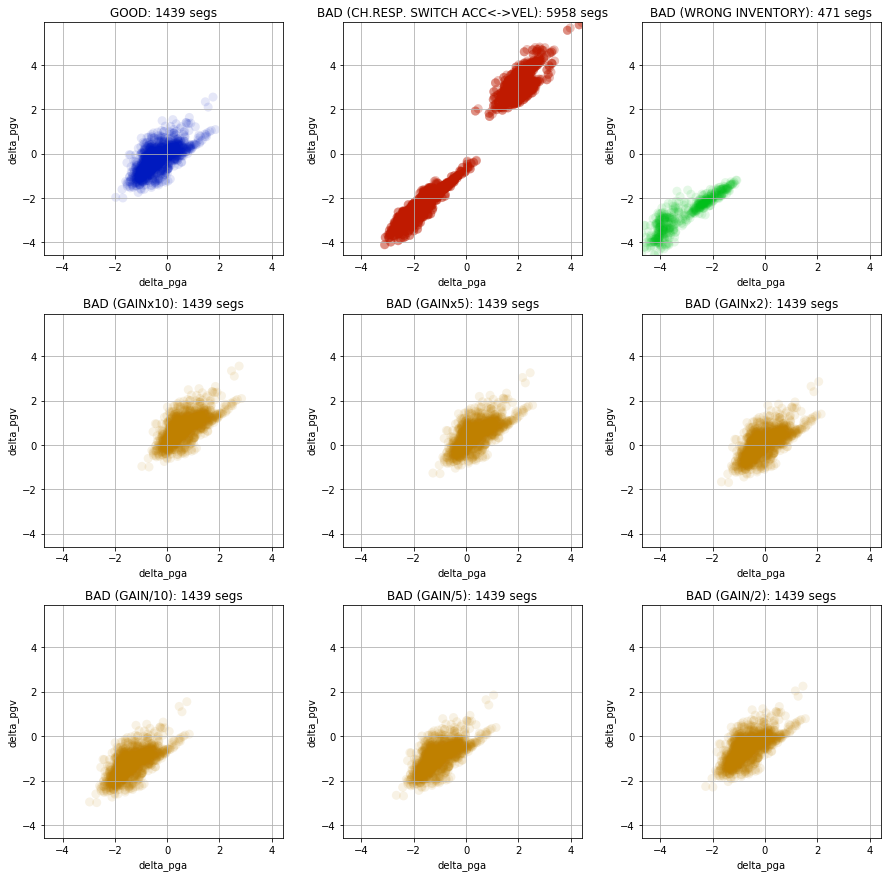

In [3]:
plot(dforig.copy(), 'delta_pga', 'delta_pgv', axis_lim=None)

<h3>Ok let's replace PGV with psd@10sec on the y axis. Observations on the plots below:
    <ul>
        <li>psd@10sec seems to well separate the good vs bad data (plots on the first row).
        <li>Still, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue)
    </ul>
</h3>

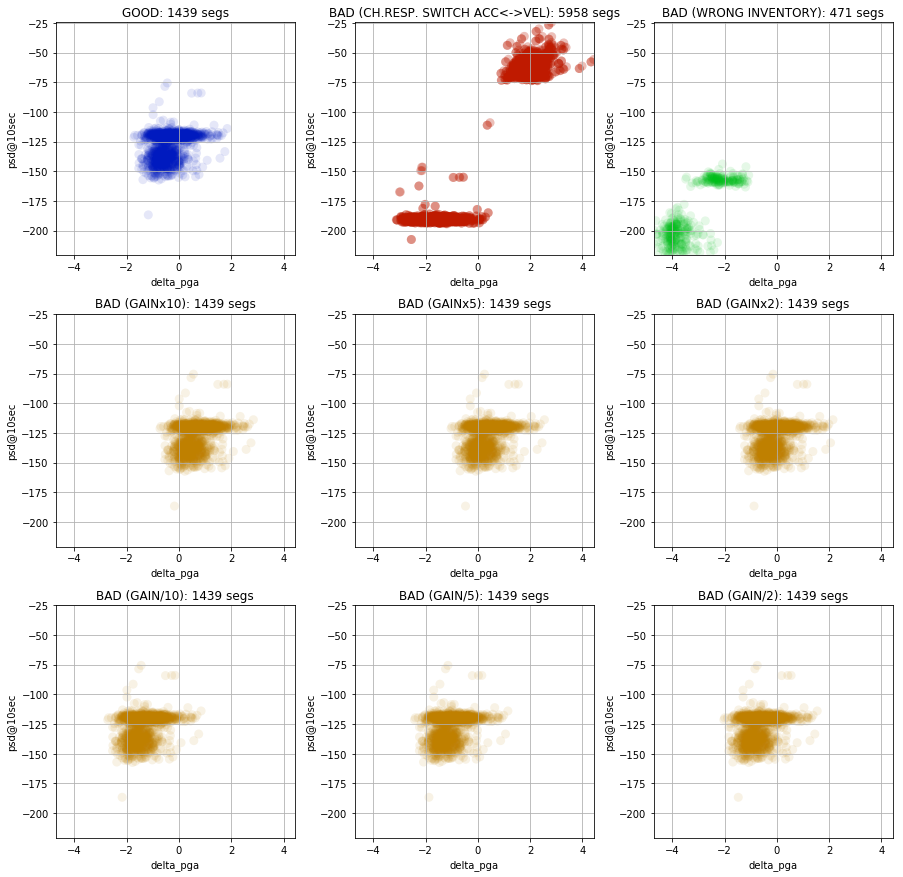

In [126]:
plot(dforig.copy(), 'delta_pga', 'psd@10sec', axis_lim=None)  # with delta_pgv does not change a lot

<h3>What if we use psd@0.1sec (the shortest period we have). Let's replace PGA with psd@0.1sec on the x axis. Observations on the plots below:
    <ul>
        <li>At low periods we have more antropic noise, but apparently if we have a really wrong inventory (first row of plots) psd@0.1sec seem to perform as psd@10sec for good vs bad data (plots on the first row).
        <li>But, changing the gain by a factor of 2,5,10 (bottom plots, yellow) does not change a lot with respect to the good ones (first plot, blue), and in this case psd@10sec performs better
    </ul>
</h3>

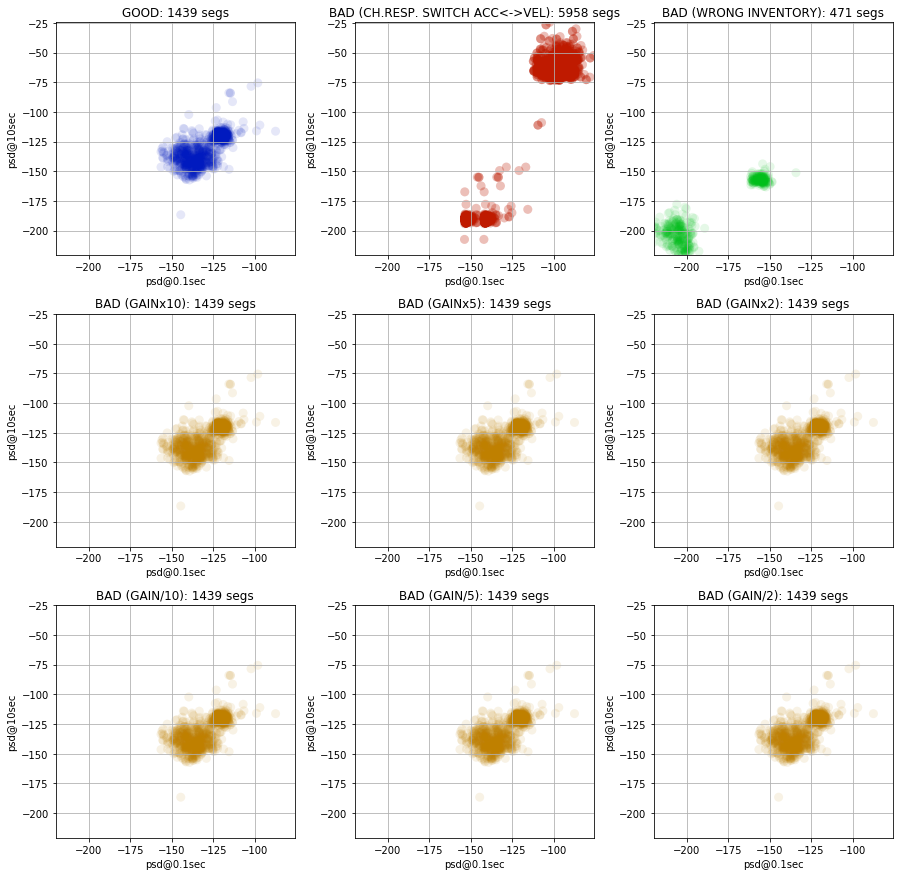

In [130]:
plot(dforig.copy(), 'psd@0.1sec', 'psd@10sec', axis_lim=None)  # with delta_pgv does not change a lot

<h3>Another try: let's psd@10sec (the lagest period we have) with some information on the signal (psd refers to the noise). Becasue psd is on the largest period, I take also the amplitude spectrum on the largest frequency (amp@10hz), 
    using the log10 of the amplitudes (Dino observation, ask why) <b>But let's keep in mind that the earthquake amplitude is a function of magnitude and distance</b>, so these plots are just a try. Observations on the plots below:
    <ul>
        <li>psd@10sec and psd@1sec seem to both well separate the good vs bad data (plots on the first row). Is this a bug? (you said that larger periods carry more information) or something interesting?
        <li>Still, changing the gain by a factor of 2,5,10 (bottom plots, yellow) improves slighly but does not change a lot with respect to the good ones (first plot, blue)
    <li>We might try to build a N dimensional space with (mag, dist, amplitudes)
    </ul>
</h3>

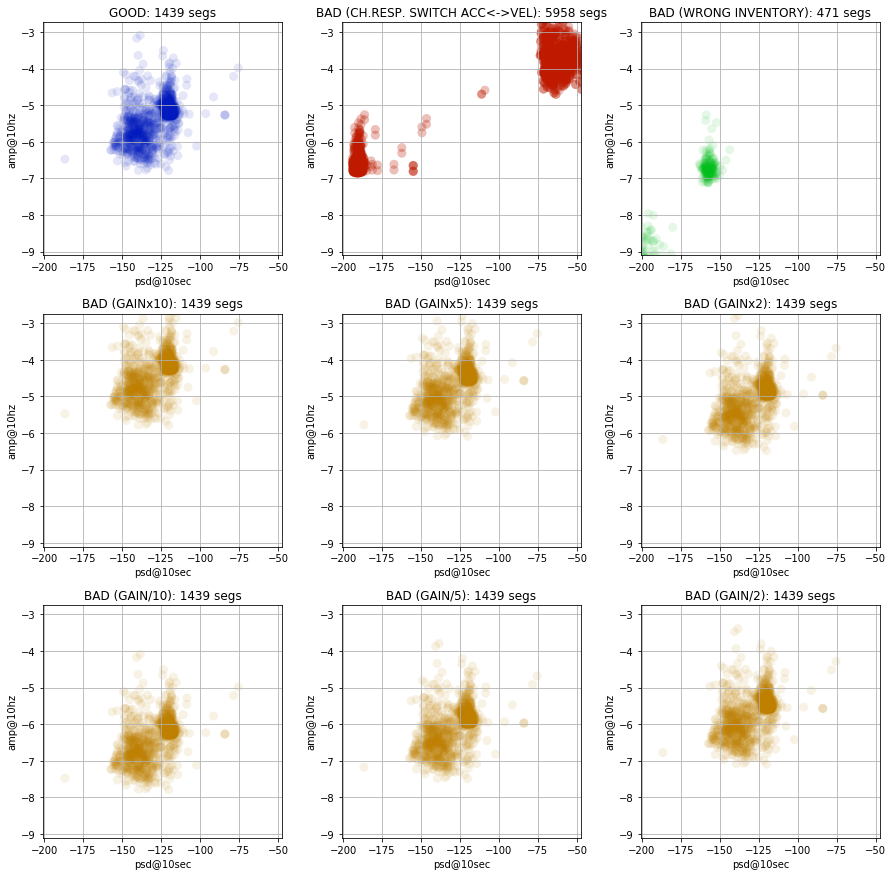

In [131]:
df_ = dforig.copy()
df_['amp@10hz'] = np.log10(df_['amp@10hz'])
plot(df_.copy(), 'psd@10sec', 'amp@10hz', axis_lim=.99)  # with delta_pgv does not change a lot

<h3>Last try: let's try to summarize the three most promising features
</h3>

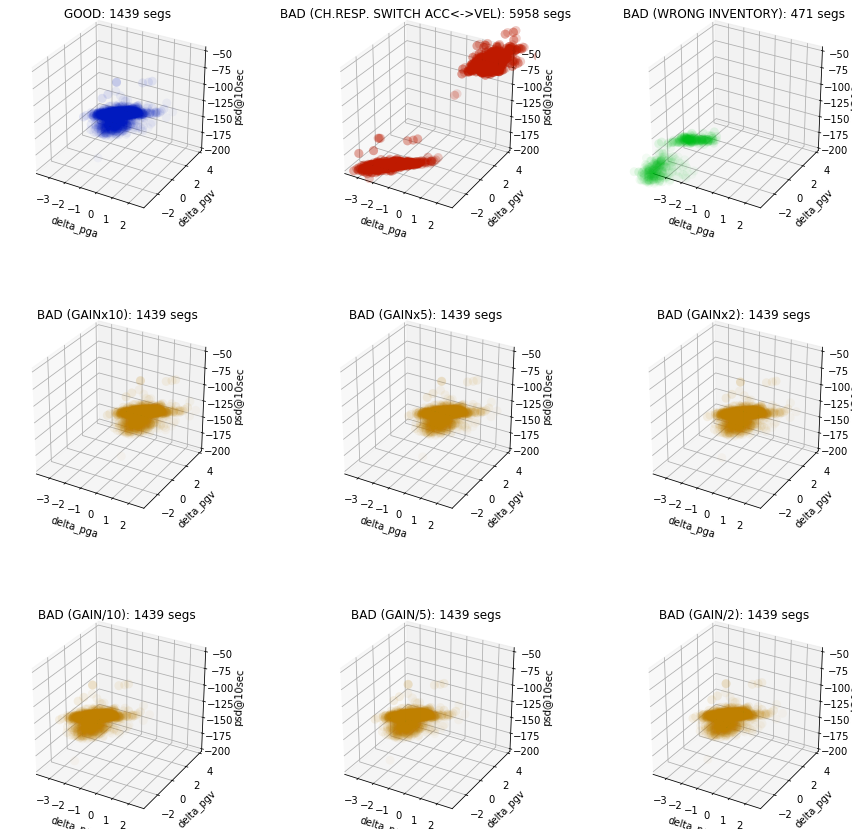

In [132]:
plot(dforig.copy(), 'delta_pga', 'delta_pgv', 'psd@10sec', axis_lim=.99)  # with delta_pgv does not change a lot